# Creating a train-test split for model evaluations

---

### package imports and basic functions

---

In [1]:
import os
import gc
import sys
import glob
import json
import random
import datetime
import importlib
import itertools
import numpy as np
from scipy import spatial
import scipy.sparse as sparse
import scipy.stats as stats
import pandas as pd
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import boto3


In [2]:
class MyNumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)


def ensure_dir(file_name):
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    return file_name


def list_dirs(path=os.getcwd()):
    files = glob.glob(os.path.join(path, '*'))
    files = [x for x in files if os.path.isdir(x)]
    return files


def file_exists(file_name, path_name=os.getcwd()):
    return os.path.isfile(os.path.join(path_name, file_name))


def write_json(json_obj, file_path):
    with open(file_path, 'w') as outfile:
        json.dump(json_obj, outfile, sort_keys=True, indent=4,
                  cls=MyNumpyEncoder)
    return json_obj


def load_json(file_path):
    with open(file_path, 'r') as infile:
        return json.load(infile)


def write_np(np_obj, file_path):
    with open(file_path, 'wb') as outfile:
        np.save(outfile, np_obj)


def load_np(file_path):
    with open(file_path, 'rb') as infile:
        return np.load(infile)


In [3]:
# path setting
main_dir = os.path.abspath('../../..')


## Load aggregated data

---

In [4]:
demography_df = pd.read_csv(f'{main_dir}/data/csv/demography_all_datasets.csv', index_col=0).reset_index(drop=True)
demography_df.head()


,age,thickness,sex,subject_ID,dataset,site,siteCode
0,32.0,2.636395,1.0,HCP-YA-130518,HCP-YA,HCP-YA-site_0,0
1,35.0,2.633850,1.0,HCP-YA-192237,HCP-YA,HCP-YA-site_0,0
2,31.0,2.704905,1.0,HCP-YA-859671,HCP-YA,HCP-YA-site_0,0
3,33.0,2.629196,0.0,HCP-YA-158136,HCP-YA,HCP-YA-site_0,0
4,22.0,2.760889,0.0,HCP-YA-192136,HCP-YA,HCP-YA-site_0,0


## Add split labels

---

In [8]:
demography_df = pd.concat([demographies[dataset_name] for dataset_name in datasets])

# encode site information
site_idxs, sites = pd.factorize(demography_df['site'])
demography_df['siteCode'] = site_idxs

demography_df.head()


,age,thickness,sex,subject_ID,dataset,site,siteCode
0,32.0,2.636395,1.0,HCP-YA-130518,HCP-YA,HCP-YA-site_0,0
1,35.0,2.633850,1.0,HCP-YA-192237,HCP-YA,HCP-YA-site_0,0
2,31.0,2.704905,1.0,HCP-YA-859671,HCP-YA,HCP-YA-site_0,0
3,33.0,2.629196,0.0,HCP-YA-158136,HCP-YA,HCP-YA-site_0,0
4,22.0,2.760889,0.0,HCP-YA-192136,HCP-YA,HCP-YA-site_0,0


In [9]:
demography_df.to_csv(ensure_dir(f'{main_dir}/data/csv/demography_all_datasets.csv'))


In [10]:
write_json(
    [f'{dataset_name}-{subject}' for dataset_name in datasets for subject in valid_subjects[dataset_name]],
    ensure_dir(f'{main_dir}/data/json/valid_subjects_all_datasets.json')
);


In [11]:
# all high-resolution thickness data
all_thickness_data = np.concatenate([thickness_data[dataset_name] for dataset_name in datasets])


In [12]:
all_thickness_data.shape

(2473, 59412)

In [13]:
write_np(all_thickness_data, ensure_dir(f'{main_dir}/data/npy/thickness_all_datasets.npy'));


In [30]:
demography_df['age_bins'] = pd.qcut(demography_df['age'], q=20, labels=False)
demography_df.head()


,age,thickness,sex,subject_ID,dataset,site,siteCode,split,age_bins
0,32.0,2.636395,1.0,HCP-YA-130518,HCP-YA,HCP-YA-site_0,0,Train,11
1,35.0,2.633850,1.0,HCP-YA-192237,HCP-YA,HCP-YA-site_0,0,Train,13
2,31.0,2.704905,1.0,HCP-YA-859671,HCP-YA,HCP-YA-site_0,0,Train,10
3,33.0,2.629196,0.0,HCP-YA-158136,HCP-YA,HCP-YA-site_0,0,Train,12
4,22.0,2.760889,0.0,HCP-YA-192136,HCP-YA,HCP-YA-site_0,0,Train,5


In [44]:
from sklearn.model_selection import train_test_split

train_indices, test_indices = train_test_split(
    np.arange(demography_df.shape[0]), train_size=0.8, random_state=0, shuffle=True, stratify=demography_df[['siteCode', 'age_bins', 'sex']]
)


In [45]:
demography_df["split"] = "Train"

demography_df.loc[test_indices, 'split'] = 'Test'


In [46]:
demography_df.to_csv(ensure_dir(f'{main_dir}/data/csv/demography_all_datasets.csv'))


## Verify stratified splits

---

In [177]:
demography_df["split"].value_counts()

Train    1978
Test      495
Name: split, dtype: int64

In [47]:
demography_df["split"].value_counts() / demography_df.shape[0]

Train    0.799838
Test     0.200162
Name: split, dtype: float64

CPU times: user 243 ms, sys: 80.9 ms, total: 324 ms
Wall time: 151 ms


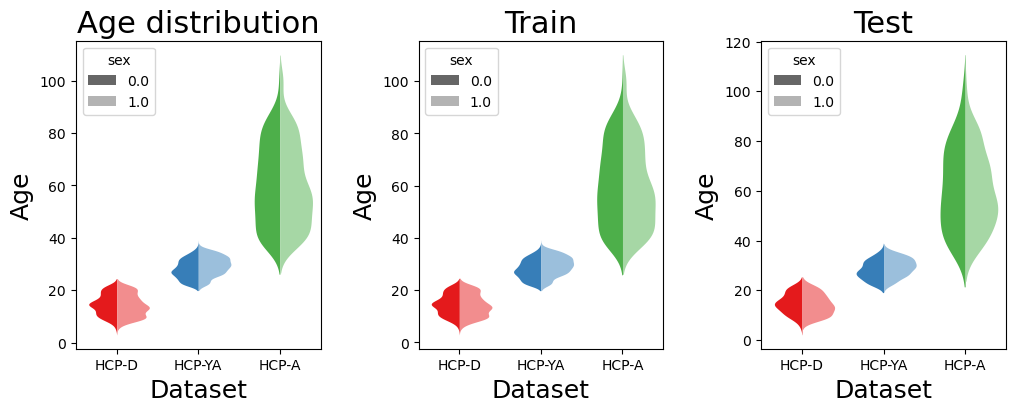

In [48]:
%%time

from matplotlib.collections import PolyCollection
from matplotlib.colors import to_rgb

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.subplots_adjust(wspace=0.4)

for i in range(3):
    ax = axes[i]
    if i == 0:
        ax.set_title('Age distribution', fontsize=22)
        sample_df = demography_df.copy()
    elif i == 1:
        ax.set_title('Train', fontsize=22)
        sample_df = demography_df[demography_df['split'] == 'Train'].copy()
    elif i == 2:
        ax.set_title('Test', fontsize=22)
        sample_df = demography_df[demography_df['split'] == 'Test'].copy()
        
        
    data_order = sample_df.groupby(by=["dataset"])["age"].median().sort_values().index

    sns.violinplot(
        data=sample_df,
        x='dataset',
        y='age',
        ax=ax,
        linewidth=0,
        hue='sex',
        palette=['.4', '.7'],
        alpha=0.5,
        split=True,
        scale="count",
        order=data_order,
    )

    colors = sns.color_palette('Set1')
    for ind, violin in enumerate(ax.findobj(PolyCollection)):
        rgb = to_rgb(colors[ind // 2])
        if ind % 2 != 0:
            rgb = 0.5 + 0.5 * np.array(rgb)  # make whiter
        violin.set_facecolor(rgb)

    ax.set_xlabel('Dataset', fontsize=18)
    ax.set_ylabel('Age', fontsize=18)



In [49]:
demography_df.head()


,age,thickness,sex,subject_ID,dataset,site,siteCode,split,age_bins
0,32.0,2.636395,1.0,HCP-YA-130518,HCP-YA,HCP-YA-site_0,0,Train,11
1,35.0,2.633850,1.0,HCP-YA-192237,HCP-YA,HCP-YA-site_0,0,Train,13
2,31.0,2.704905,1.0,HCP-YA-859671,HCP-YA,HCP-YA-site_0,0,Train,10
3,33.0,2.629196,0.0,HCP-YA-158136,HCP-YA,HCP-YA-site_0,0,Train,12
4,22.0,2.760889,0.0,HCP-YA-192136,HCP-YA,HCP-YA-site_0,0,Test,5
